我们用到的环境是一个经典的环境，悬崖边行走（cliff walking）。

图中，绿色的是地面，深棕色的地方表示悬崖，小人的目标是要尽可能快地从左下角的起点走到右下角的终点，掉下悬崖会得到-100的收益。除此之外，每转移一步得到-1的收益。

![](cliff_walk.png)

Gym中已经有现成的环境可以调用，但是这里我们自己写一个，也是为了整个代码可以是self-contained。

一共有3*12+1(起点)=37个状态需要确定动作，每个状态给其一个标记：当前智能体所在行\*总列数+当前智能体所在列。

坐标系原点[0, 0]位于左上角

举个例子，起点[0, 3]的标记为：$3*12+0=36$

In [25]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [26]:
class CliffWalkingEnv(object):
    def __init__(self, nrow=4, ncol=12):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 智能体当前位置的横坐标，即所在的列
        self.y = self.nrow - 1  # 智能体当前位置的纵坐标，即所在的行

    def step(self, action):
        # 4种动作，上: 0，下: 1, 左: 2, 右: 3
        # if action == 0:
        #     self.y = max(self.y - 1, 0)
        # elif action == 1:
        #     self.y = min(self.y + 1, self.nrow - 1)
        # elif action == 2:
        #     self.x = max(self.x - 1, 0)
        # elif action == 3:
        #     self.x = min(self.x + 1, self.ncol - 1)
        # else:
        #     assert False, "action must be 0, 1, 2, 3." 
        
        # 再提供一种更简洁的写法，但是就不那么容易理解了
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))

        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False

        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者终点
            done = True
            if self.x != self.ncol - 1:  # 掉下悬崖
                reward = -100
        
        return next_state, reward, done
    
    def reset(self):  # 回到起点
        self.x = 0
        self.y = self.nrow - 1

        return self.y * self.ncol + self.x

# Dyna-Q

![](Dyna-Q.png)

Dyna-Q是一种基于模型的强化学习。它的主要思想是在无模型的方法（比如Q-learning）的基础上，利用与环境交互的数据构建环境的模型，然后从环境模型中进行采样模拟数据，并与真实数据一起用来改进策略。这样可以提高样本的使用效率，如果模型构建的好，还可以加快算法收敛的速度。

In [86]:
class DynaQ(object):
    def __init__(self, nrow, ncol, n_action, epsilon, alpha, gamma, n_planning):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境模型
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state, :])
        
        return action
    
    def q_learning(self, state, action, r, next_state):
        td_error = r + self.gamma * np.max(self.Q_table[next_state, :]) - self.Q_table[state, action]
        self.Q_table[state, action] += self.alpha * td_error

    def update_env_model(self, state, action, r, next_state):
        self.q_learning(state, action, r, next_state)   # 自己写的时候漏了这一步，导致一条轨迹永远不会终止...
        self.model[(state, action)] = r, next_state  # 将数据添加到模型中，cliff walking这个环境状态转移是确定的，所以构建的模型也是准确的
        for _ in range(self.n_planning):   # Q-planning 循环
            # 随机选择曾经遇到过的状态-动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)
   

## training

In [88]:
def training(n_planning):
    nrow = 4
    ncol = 12
    n_action = 4
    env = CliffWalkingEnv(nrow, ncol)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(nrow, ncol, n_action, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                ep_return = 0
                state = env.reset()
                done = False
                while True:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    ep_return += reward  # 为了简化就不计算折扣因子了
                    agent.update_env_model(state, action, reward, next_state)
                    state = next_state
                    if done == True:
                        break
                return_list.append(ep_return)

                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    
    return return_list, agent


Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1253.23it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 273.45it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 131.36it/s, episode=300, return=-13.400]


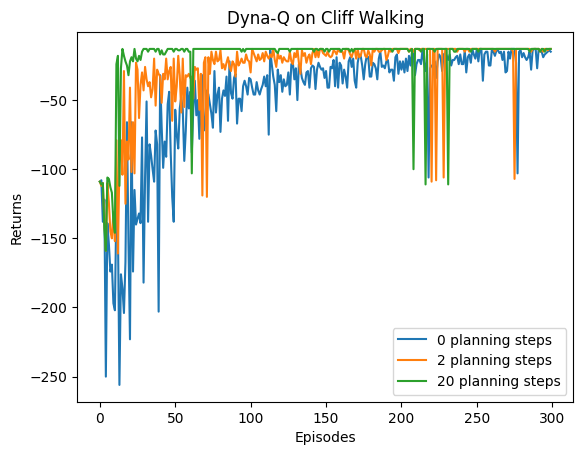

In [89]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list, _ = training(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

## Policy Visualization

In [90]:
_, agent = training(n_planning)

Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 128.01it/s, episode=300, return=-23.000]


In [95]:
from pprint import pprint

In [106]:
action_mean = ['↑', '↓', '←', '→']
policy = []
for i in range(4):
    tmp = []
    for j in range(12):    
        tmp.append(action_mean[np.argmax(agent.Q_table[i*12+j])])
    policy.append(tmp)
policy[3][1:-1] = 'x' * 10
pprint(policy)

[['→', '→', '→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
 ['→', '→', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓'],
 ['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓'],
 ['↑', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '↑']]
